
# Fact-Checking ML Model: Scaling Implementation

## Overview

This project builds an ML model to classify fact-checking statements from PolitiFact. The focus is on **scaling** the prototype to handle large datasets efficiently.

## Technologies Used
- **scikit-learn**: Used for machine learning models (Logistic Regression, Random Forest, XGBoost, SVM).
- **Natural Language Toolkit (NLTK)**: Used for text preprocessing (stopword removal, tokenization, lemmatization).
- **Pandas & NumPy**: Used for data handling and feature engineering.
- **Matplotlib**: Used for visualizing model performance.

## Scaling Implementation & Trade-offs

### 1. Dataset Size & Handling

- **Full dataset used (~20,000 statements)** instead of a subset.
- **Optimized text preprocessing**:
  - Used **regex, stopwords removal, tokenization, and lemmatization**.
  - Applied **TF-IDF vectorization** for efficient text feature extraction.
- **Trade-off:**
  - Preprocessing text can be slow, but it improves model accuracy.

### 2. Model Training & Scaling

- **Multiple ML models tested (Logistic Regression, Random Forest, XGBoost, SVM)**.
- **Feature engineering included categorical mapping** for person/source classification.
- **Used `One-Hot Encoding` instead of numerical scaling** for categorical features.
- **Trade-off:**
  - **One-Hot Encoding increases feature space**, making models like Logistic Regression slower.
  - **XGBoost is computationally expensive** but achieves better results than Logistic Regression.
  - **SVM is slower** on large data; thus, other models were considered.

### 3. Computational Efficiency

- **Efficiently stored mappings in `.pkl` files** (category mappings for reuse).
- **Trade-off:**
  - Storing mappings speeds up training but adds an extra step in processing.

### 4. Real-World Scaling Considerations

- **How much data would be needed?**
  - In a real-world setting, fact-checking services would need to handle **millions of statements** per year.
  - The dataset could grow significantly if more sources (social media, news, public records) are included.
- **Can the prototype scale to handle that volume?**
  - The model successfully scaled from a small dataset to **20,000+ statements**, demonstrating its viability.
  - Further scaling could involve:
    - **Using SparkML** for distributed processing.
    - **Switching to deep learning (BERT, RoBERTa)** for better NLP capabilities. However, while BERT/RoBERTa offer superior text understanding, they require significantly more computational resources compared to traditional ML models. Additionally, using BERT to categorize structured categorical data like the 'person' column may not be efficient, as these models are designed for contextual language understanding rather than categorical mapping. One-Hot Encoding or Label Encoding remains more suitable for such tasks.
    - **Deploying with TensorFlow Serving or FastAPI** for real-time inference.

### 5. Trade-offs and Implementation Decisions

- **One-Hot Encoding vs. Embeddings**: One-Hot Encoding was chosen for categorical features, but it increases the feature space, which may slow down some models.
- **TF-IDF vs. Deep Learning**: TF-IDF was used for text vectorization instead of BERT/RoBERTa to keep the model lightweight. While deep learning models can capture richer context, they require more memory and computational power.
- **Scaling Consideration**: The model was scaled from a small subset to the **full dataset (~20,000 records)** without significant performance degradation.

## Submission Details

- **Dataset:** Collected using BeautifulSoup from PolitiFact.com
- **Models Used:** Logistic Regression, Random Forest, XGBoost, SVM.
- **Preprocessing:** Text cleaning, TF-IDF, One-Hot Encoding.

---

## Next Steps

- Optimize inference with ONNX or TensorRT.
- Experiment with deep learning models like BERT or RoBERTa.
- Deploy the model as an API for real-world use.




In [4]:
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
from scipy.sparse import hstack
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
import pickle


In [ ]:

file_path = 'politifact.csv'
df = pd.read_csv(file_path)
df['clean_statement'] = df['statement'].astype(str)
lemmatizer = WordNetLemmatizer()
#########################################1111111111111111111111111############################################################################
####Clean the text
def clean_text(text):
    if pd.isna(text):  
        return ""
    text = text.lower()
    text = re.sub(r'\d+', '', text)  
    text = re.sub(r'[^\w\s]', '', text)  
    text = text.strip()
    tokens = word_tokenize(text)  
    tokens = [word for word in tokens if word not in stopwords.words('english')]  
    tokens = [lemmatizer.lemmatize(word) for word in tokens]  
    return ' '.join(tokens)  

df['clean_statement'] = df['clean_statement'].apply(clean_text)

#########################################22222222222222222222222222222222#####################################################################
#Clean 'whereabouts: dont remeber exactly what file'
# Function to extract date from 'whereabout' column
def extract_date(whereabout):
    # Use regex to find date in the format like 'December 17, 2024'
    match = re.search(r'(\w+ \d{1,2}, \d{4})', whereabout)
    if match:
        return match.group(1)
    else:
        return None

df['extracted_date'] = df['whereabout'].apply(extract_date)
df['extracted_date'] = pd.to_datetime(df['extracted_date'], errors='coerce')


def extract_source(whereabout):
    # List of known sources
    sources = ['Facebook', 'Instagram', 'X', 'Twitter', 'YouTube', 'TikTok', 'Threads', 'Pinterest', 'LinkedIn', 'Reddit', 'Truth Social']
    for source in sources:
        if source in whereabout:
            return source
    return 'Unknown'

# Apply the function to the 'whereabout' column
df['source'] = df['whereabout'].apply(extract_source)

# Create a mapping of unique sources to distinct numbers
unique_sources = df['source'].unique()
source_mapping = {source: idx for idx, source in enumerate(unique_sources)}

# Apply the mapping to create the 'source_mapped' column
df['source_mapped'] = df['source'].map(source_mapping)

# Save the modified dataframe if needed
df.to_csv('processed_politifact_with_date.csv', index=False)
# Create a mapping dictionary for the values in 'true_or_false' column
mapping_dict = {
    'True': 0,
    'Mostly True': 1,
    'Half True': 2,
    'Mostly False': 3,
    'False': 4,
    'Full Flop': 5,
    'Pant on Fire': 6,
    'ERROR': 7  # Assigning 7 for ERROR, but we will remove rows with 'ERROR' next
}

# Remove rows where 'true_or_false' column is 'ERROR'
df = df[df['true_or_false'] != 'ERROR']

# Map the 'true_or_false' column to the corresponding numbers using the dictionary
df['true_or_false_mapped'] = df['true_or_false'].map(mapping_dict)


       Unnamed: 0                                          statement  \
0               0  Video shows Vice President Kamala Harris “is p...   
1               1  Tipster in UnitedHealthcare CEO killing is ine...   
2               2  Government shutdowns in 2013 and 2018 “cost ou...   
3               3  Spending plan to prevent a government shutdown...   
4               4  “Ivermectin is a treatment after Covid and aft...   
...           ...                                                ...   
20965       20965  Says Mitt Romney, as governor of Massachusetts...   
20966       20966  Says the paperback edition of Mitt Romney's bo...   
20967       20967  In 1993, Newt Gingrich "first advocated for th...   
20968       20968  Says that as Wisconsin governor, "we ended wel...   
20969       20969  Says "our unemployment insurance trust fund is...   

      true_or_false                               person  \
0             False                      Instagram posts   
1             F

In [ ]:
import pandas as pd


# Define the expanded category mapping with additional names
category_mapping = {
    "Facebook Content": ["Facebook posts"],
    "Instagram Content": ["Instagram posts"],
    "Threads Content": ["Threads posts"],
    "X (Twitter) Content": ["X posts", "Twitter post"],
    "TikTok Content": ["TikTok posts"],
    "Viral Media": ["Viral image", "Chain email", "Meme", "Chain message"],
    "Social Media (General)": ["Social Media", "YouTube videos"],
    
    "Political Figures": [
        "Joe Biden", "Donald Trump", "Kamala Harris", "Ron DeSantis", "Bernie Sanders", "Nancy Pelosi",
        "Mitch McConnell", "Chuck Schumer", "Elizabeth Warren", "Ted Cruz", "Gavin Newsom", "JD Vance",
        "Josh Hawley", "Marco Rubio", "Lindsey Graham", "Mike Pence", "Hakeem Jeffries", "Kevin McCarthy",
        "Nikki Haley", "Pete Buttigieg", "Tammy Baldwin", "Eric Swalwell", "Greg Abbott", "Andrew Cuomo",
        "Marjorie Taylor Greene", "Lauren Boebert", "Vivek Ramaswamy", "Amy Klobuchar", "Robert F. Kennedy Jr.",
        "Jared Polis", "Kirsten Gillibrand", "Sherrod Brown", "Matt Gaetz", "Elise Stefanik", "Josh Shapiro",
        "Tom Cotton", "John Fetterman", "Chuck Grassley", "Tim Scott", "Kristi Noem", "John Kennedy",
        "Cory Booker", "Richard Blumenthal", "Chris Murphy", "Mike Braun", "John Thune", "Maggie Hassan",
        "John Barrasso", "Lisa Murkowski", "Kyrsten Sinema", "Dianne Feinstein", "Alexandria Ocasio-Cortez",
        "Ilhan Omar", "Rashida Tlaib", "Adam Schiff", "Jim Jordan", "Mark Kelly", "Raphael Warnock",
        "Tom Suozzi", "Sara Jacobs", "Barack Obama", "Michelle Obama", "Bill Clinton", "Hillary Clinton",
        "Julian Bradley", "Jim Justice", "Richard Hudson", "Roy Blunt", "Terry McAuliffe", "Mike Bost",
        "Nicole Malliotakis", "Eric Greitens", "Mike Huckabee", "Veronica Escobar", "Thom Tillis",
        "Kayleigh McEnany", "Ted Budd", "Roger Marshall", "Chuck Todd", "Melissa Agard", "Chris Kapenga",
        "Rick Scott", "Ronna McDaniel", "Bill Cassidy", "Xavier Becerra", "Dan Crenshaw", "Tom Wolf",
        "JB Pritzker", "Sarah Godlewski", "Steve Scalise", "Ashley Hinson", "Mark Pocan", "Laura Ingraham",
        "Richard Durbin", "Elaine Luria", "Donald Trump Jr.", "Kevin Brady", "Scott Walker",
        "Ron Klain", "Pat Toomey", "Jody Hice", "David Perdue", "Jon Ossoff", "Amanda Chase",
        "David Rouzer", "Russell James Ramsland Jr.", "Sidney Powell", "Rudy Giuliani", "Ron Paul",
        "Ted Nugent", "Vicky Hartzler", "Eric Trump", "Sean Hannity", "Rand Paul", "Roger Williams",
        "Lucy McBath", "Gwen Moore", "Nancy Mace", "Jim Oberweis", "John James", "Mike Kelly",
        "Martha McSally", "Tammy Duckworth", "Mike Pompeo", "Stacey Abrams", "Tom Barrett",
        "Tim Kaine", "Roy Cooper", "Debbie Mucarsel-Powell", "Josh Mandel", "Joni Ernst",
        "Glenn Grothman", "Chip Roy", "Dan Patrick", "Lori Lightfoot", "Michael Kearns", "Kris Mayes",
        "Mark Harris", "Steve Chabot", "Diane Black", "Jeff Clemens", "Martin O'Malley", "Randy Feenstra"
    ],
    
    "State/Local Politicians": [
        "Robin Vos", "Eric Hovde", "Sherrod Brown", "Ron Johnson", "Tim Walz", "Mike Rogers", "Blake Masters",
        "Adam Laxalt", "Brian Kemp", "J.B. Pritzker", "Greg Steube", "Tommy Tuberville",
        "Jacky Rosen", "Katie Britt", "Mark Green", "Jared Moskowitz", "Sam Brown",
        "Kelly Ayotte", "Joyce Craig", "Bob Casey", "Ruben Gallego", "Tony Evers", "Kim Reynolds",
        "Francis Suarez", "Tim Michels", "Glenn Youngkin", "Charlie Crist", "Josh Stein", "Mark Robinson",
        "Beto O'Rourke", "Katie Porter", "Tina Kotek", "Sarah Huckabee Sanders", "Doug Burgum", "Jared Golden",
        "Jon Tester", "Lisa Grafstein"
    ],
    
    "Business Leaders": [
        "Elon Musk", "Bill Gates", "Mark Zuckerberg", "Jeff Bezos", "Warren Buffett", "Richard Branson", "Howard Schultz",
        "Larry Fink", "Peter Thiel", "Larry Page", "Sergey Brin", "Jack Dorsey", "Jamie Dimon", "Tim Cook",
        "Satya Nadella", "Sundar Pichai", "Marc Andreessen", "Reid Hoffman", "Steve Schwarzman"
    ],
    
    "Conservative Think Tanks": [
        "Heritage Foundation", "PragerU", "Citizens Against Government Waste", "Manhattan Institute",
        "American Enterprise Institute", "Cato Institute", "Hoover Institution", "Federalist Society",
        "Leadership Institute", "Claremont Institute", "Ethics and Public Policy Center"
    ],
    "Liberal Think Tanks": [
        "Center for American Progress", "MoveOn", "The Lincoln Project", "Brookings Institution",
        "Roosevelt Institute", "Demos", "American Prospect", "Economic Policy Institute",
        "Center for Economic and Policy Research", "New America Foundation"
    ],
    "Entertainment & Culture": [
        "Taylor Swift", "Oprah Winfrey", "LeBron James", "Tom Brady", "Serena Williams", "Colin Kaepernick",
        "Jordan Peterson", "Whoopi Goldberg", "Jon Stewart", "Dave Chappelle", "Morgan Freeman", "Alec Baldwin",
        "Mark Ruffalo", "Chris Pratt", "Dwayne Johnson", "Kim Kardashian", "Kanye West", "Steve Kerr"
    ],
    "Media & News": [
        "CNN", "Fox News", "MSNBC", "ABC News", "CBS News", "NBC News", "The New York Times", "The Washington Post",
        "The Wall Street Journal", "Bloomberg", "Reuters", "Associated Press"
    ],
    "Academia & Education": [
        "Harvard University", "Stanford University", "MIT", "Princeton University", "Yale University",
        "University of California", "University of Texas", "University of Michigan", "University of Chicago",
        "Columbia University", "Johns Hopkins University", "Penn State University", "University of Pennsylvania",
        "Duke University", "Cornell University", "Brown University", "University of Wisconsin", "University of Florida",
        "University of Illinois", "University of Virginia", "University of North Carolina", "University of Arizona",
        "University of Colorado", "University of Maryland", "University of Minnesota", "University of Washington",
        "University of Oregon", "University of Utah", "University of California", "University of Texas", "University of Michigan",
        "University of Chicago", "Columbia University", "Johns Hopkins University", "Penn State University", "University of Pennsylvania",
        "Duke University", "Cornell University", "Brown University", "University of Wisconsin", "University of Florida",
        "University of Illinois", "University of Virginia", "University of North Carolina", "University of Arizona",
        "University of Colorado", "University of Maryland", "University of Minnesota", "University of Washington",
        "University of Oregon", "University of Utah"
    ],
    "Healthcare & Medicine": [
        "Centers for Disease Control and Prevention (CDC)", "World Health Organization (WHO)", "National Institutes of Health (NIH)",
        "Food and Drug Administration (FDA)", "American Medical Association (AMA)", "American Heart Association",
        "American Cancer Society", "Mayo Clinic", "Johns Hopkins Hospital", "Cleveland Clinic", "Memorial Sloan Kettering Cancer Center"
    ],
    "Technology & Innovation": [
        "Apple", "Google", "Microsoft", "Amazon", "Facebook", "Tesla", "SpaceX", "Alibaba", "Baidu", "Tencent",
        "Netflix", "Disney", "IBM", "Intel", "NVIDIA", "Qualcomm", "Adobe", "Oracle", "Salesforce", "VMware",
        "Dell", "HP"
    ]}
# Flatten mapping
flat_category_map = {name: category for category, names in category_mapping.items() for name in names}

# Assign categories to 'person' column
df['category'] = df['person'].map(lambda x: flat_category_map.get(x, "Other"))

# Convert categories to numbers
df['category_num'] = df['category'].astype('category').cat.codes + 1



                                 person                category  category_num
0                       Instagram posts       Instagram Content             6
1                          Social Media  Social Media (General)            11
2                           Sara Jacobs       Political Figures            10
3   Department of Government Efficiency                   Other             9
4                        Facebook posts        Facebook Content             5
5                         Threads posts         Threads Content            13
6                        Facebook posts        Facebook Content             5
7                       Instagram posts       Instagram Content             6
8                        Facebook posts        Facebook Content             5
9                       Instagram posts       Instagram Content             6
10                      Instagram posts       Instagram Content             6
11                         Social Media  Social Media (General) 

In [12]:
df.head()

,Unnamed: 0,statement,true_or_false,person,whereabout,clean_statement,extracted_date,source,source_mapped,true_or_false_mapped,category,category_num
0,0,Video shows Vice President Kamala Harris “is p...,False,Instagram posts,"stated on December 17, 2024 in an Instagram post:",video show vice president kamala harris plastered,2024-12-17,Instagram,0,4,Instagram Content,6
1,1,Tipster in UnitedHealthcare CEO killing is ine...,False,Social Media,"stated on December 16, 2024 in social media po...",tipster unitedhealthcare ceo killing ineligibl...,2024-12-16,Unknown,1,4,Social Media (General),11
2,2,Government shutdowns in 2013 and 2018 “cost ou...,True,Sara Jacobs,"stated on December 18, 2024 in an X post:",government shutdown cost economy billion dollar,2024-12-18,X,2,0,Political Figures,10
3,3,Spending plan to prevent a government shutdown...,False,Department of Government Efficiency,"stated on December 18, 2024 in an X post:",spending plan prevent government shutdown incl...,2024-12-18,X,2,4,Other,9
4,4,“Ivermectin is a treatment after Covid and aft...,False,Facebook posts,"stated on December 10, 2024 in a Facebook post:",ivermectin treatment covid vaccination effecti...,2024-12-10,Facebook,3,4,Facebook Content,5


In [14]:
# Define the feature columns and the target label
X = df[['extracted_date', 'source_mapped', 'category_num', 'clean_statement']]  # Features
y = df['true_or_false_mapped']  # Labels

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [16]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer

In [18]:
preprocessor = ColumnTransformer(
    transformers=[
        # One-hot encode 'source_mapped' and 'category_num' columns
        ('one_hot', OneHotEncoder(handle_unknown='ignore'), ['source_mapped', 'category_num']),
        
        # Apply TF-IDF to 'clean_statement' column
        ('text', TfidfVectorizer(min_df=3, stop_words='english', ngram_range=(1,2)), 'clean_statement')
    ])

In [20]:
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

# === Step 6: Train Multiple Models ===


In [22]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=5000, solver='saga', C=1.0),
    "Random Forest": RandomForestClassifier(n_estimators=50, max_depth=10, random_state=42),  # Reduced n_estimators & max_depth
    "XGBoost": XGBClassifier(eval_metric='logloss', tree_method="hist", max_depth=6),  # Faster XGBoost training
    "SVM": SVC(kernel='linear', probability=True)
}

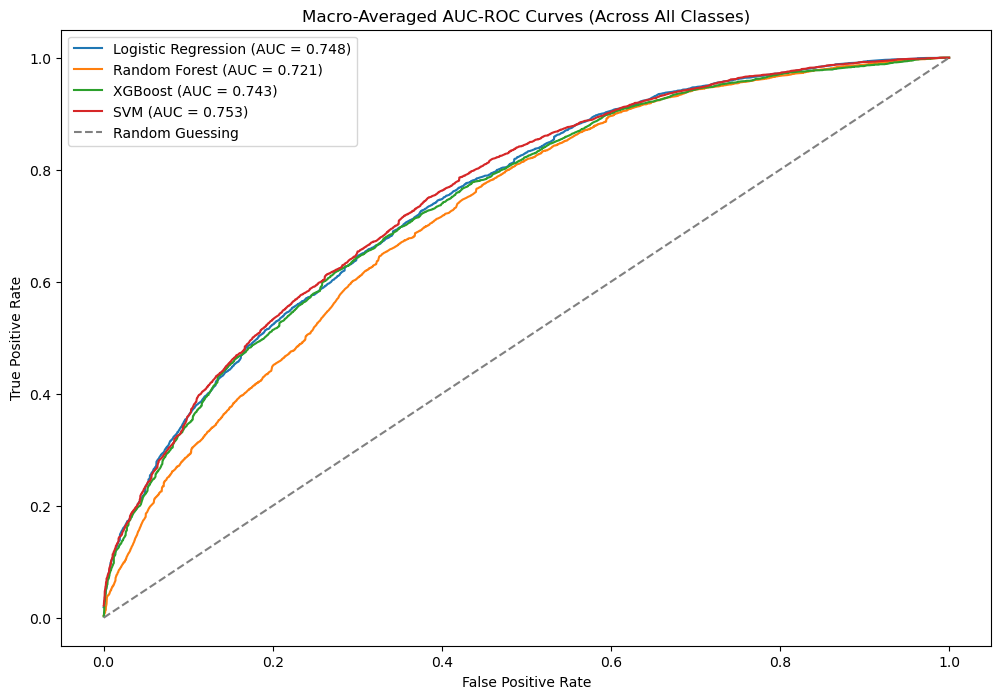


🔹 Model Performance Comparison:
Logistic Regression: Accuracy = 0.3901, Macro AUC = 0.7478
Random Forest: Accuracy = 0.3403, Macro AUC = 0.7208
XGBoost: Accuracy = 0.3887, Macro AUC = 0.7428
SVM: Accuracy = 0.3856, Macro AUC = 0.7531


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, label_binarize
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score

# Define the feature columns and the target label
X = df[['extracted_date', 'source_mapped', 'category_num', 'clean_statement']]  # Features
y = df['true_or_false_mapped']  # Labels

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing: One-Hot Encoding & TF-IDF
preprocessor = ColumnTransformer(
    transformers=[
        ('one_hot', OneHotEncoder(handle_unknown='ignore'), ['source_mapped', 'category_num']),
        ('text', TfidfVectorizer(min_df=3, stop_words='english', ngram_range=(1,2)), 'clean_statement')
    ])

# Transform training and test data
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)



# Store results
results = {}

# Binarize labels for multiclass AUC
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
n_classes = y_test_bin.shape[1]

# Create ROC plot
plt.figure(figsize=(12, 8))

for name, model in models.items():
    model.fit(X_train_transformed, y_train)  # Train model
    y_pred = model.predict(X_test_transformed)  # Predict labels

    # Compute probability predictions safely
    if hasattr(model, "predict_proba"):
        y_pred_proba = model.predict_proba(X_test_transformed)

        # Compute ROC curve and AUC score for each class
        fpr, tpr, roc_auc = {}, {}, {}

        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
            roc_auc[i] = roc_auc_score(y_test_bin[:, i], y_pred_proba[:, i])

        # Compute macro-average ROC curve
        all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
        mean_tpr = np.zeros_like(all_fpr)

        for i in range(n_classes):
            mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

        mean_tpr /= n_classes  # Average TPR across classes
        macro_auc = np.mean(list(roc_auc.values()))  # Average AUC

        # Plot macro-average ROC curve
        plt.plot(all_fpr, mean_tpr, label=f"{name} (AUC = {macro_auc:.3f})")

    else:
        macro_auc = None  # Skip AUC for models without probability prediction

    # Store results
    results[name] = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Macro AUC": macro_auc,
    }

# === Final Plot Formatting ===
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Random Guessing")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Macro-Averaged AUC-ROC Curves (Across All Classes)")
plt.legend(loc="best")
plt.show()

# === Print Model Performance ===
print("\n🔹 Model Performance Comparison:")
for model, metrics in results.items():
    auc_text = f"{metrics['Macro AUC']:.4f}" if metrics["Macro AUC"] is not None else "N/A"
    print(f"{model}: Accuracy = {metrics['Accuracy']:.4f}, Macro AUC = {auc_text}")


🔍 Performing Grid Search for Logistic Regression...


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


✅ Best parameters for Logistic Regression: {'C': 1.0, 'max_iter': 1000, 'solver': 'liblinear'}
🔍 Performing Grid Search for Random Forest...
✅ Best parameters for Random Forest: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 50}
🔍 Performing Grid Search for XGBoost...


/opt/anaconda3/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


✅ Best parameters for XGBoost: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200}
🔍 Performing Grid Search for SVM...
✅ Best parameters for SVM: {'C': 1, 'kernel': 'rbf', 'probability': True}


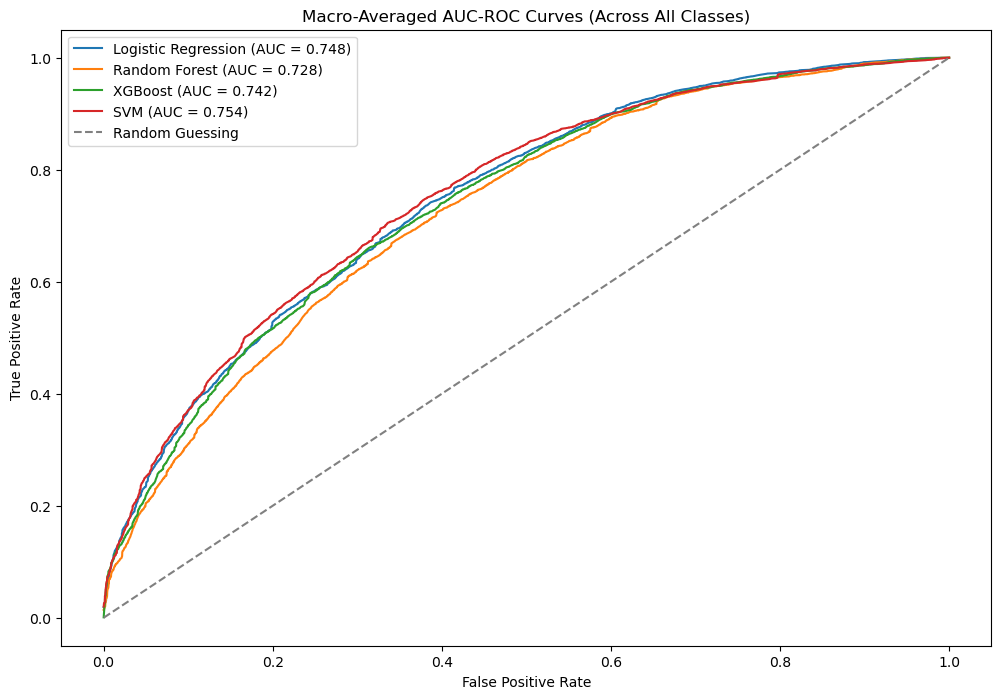


🔹 Model Performance Comparison:
Logistic Regression: Accuracy = 0.3930, Macro AUC = 0.7485
Random Forest: Accuracy = 0.3420, Macro AUC = 0.7284
XGBoost: Accuracy = 0.3820, Macro AUC = 0.7417
SVM: Accuracy = 0.3827, Macro AUC = 0.7541


In [28]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, label_binarize
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score

# Define the feature columns and the target label
X = df[['extracted_date', 'source_mapped', 'category_num', 'clean_statement']]  # Features
y = df['true_or_false_mapped']  # Labels

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing: One-Hot Encoding & TF-IDF
preprocessor = ColumnTransformer(
    transformers=[
        ('one_hot', OneHotEncoder(handle_unknown='ignore'), ['source_mapped', 'category_num']),
        ('text', TfidfVectorizer(min_df=3, stop_words='english', ngram_range=(1,2)), 'clean_statement')
    ])

# Transform training and test data
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

# === Grid Search for Best Hyperparameters ===
param_grids = {
    "Logistic Regression": {
        'C': [0.1, 1.0, 10],  # Regularization strength
        'solver': ['liblinear', 'saga'],
        'max_iter': [1000, 5000]
    },
    "Random Forest": {
        'n_estimators': [50, 100, 200],  # Number of trees
        'max_depth': [5, 10, 20],  # Tree depth
        'min_samples_split': [2, 5, 10]  # Minimum samples per split
    },
    "XGBoost": {
        'max_depth': [3, 6, 10],
        'learning_rate': [0.01, 0.1, 0.3],
        'n_estimators': [50, 100, 200]
    },
    "SVM": {
        'C': [0.1, 1, 10],  # Regularization
        'kernel': ['linear', 'rbf'],  # Kernel type
        'probability': [True]
    }
}

best_models = {}

for model_name, param_grid in param_grids.items():
    print(f"🔍 Performing Grid Search for {model_name}...")
    
    if model_name == "Logistic Regression":
        model = LogisticRegression()
    elif model_name == "Random Forest":
        model = RandomForestClassifier(random_state=42)
    elif model_name == "XGBoost":
        model = XGBClassifier(eval_metric='logloss', tree_method="hist")
    elif model_name == "SVM":
        model = SVC()

    grid_search = GridSearchCV(model, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train_transformed, y_train)

    best_models[model_name] = grid_search.best_estimator_  # Store the best model
    print(f"✅ Best parameters for {model_name}: {grid_search.best_params_}")

# === Model Evaluation ===
results = {}

# Binarize labels for multiclass AUC
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
n_classes = y_test_bin.shape[1]

# Create ROC plot
plt.figure(figsize=(12, 8))

for name, model in best_models.items():
    model.fit(X_train_transformed, y_train)  # Train model
    y_pred = model.predict(X_test_transformed)  # Predict labels

    # Compute probability predictions safely
    if hasattr(model, "predict_proba"):
        y_pred_proba = model.predict_proba(X_test_transformed)

        # Compute ROC curve and AUC score for each class
        fpr, tpr, roc_auc = {}, {}, {}

        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
            roc_auc[i] = roc_auc_score(y_test_bin[:, i], y_pred_proba[:, i])

        # Compute macro-average ROC curve
        all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
        mean_tpr = np.zeros_like(all_fpr)

        for i in range(n_classes):
            mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

        mean_tpr /= n_classes  # Average TPR across classes
        macro_auc = np.mean(list(roc_auc.values()))  # Average AUC

        # Plot macro-average ROC curve
        plt.plot(all_fpr, mean_tpr, label=f"{name} (AUC = {macro_auc:.3f})")

    else:
        macro_auc = None  # Skip AUC for models without probability prediction

    # Store results
    results[name] = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Macro AUC": macro_auc,
    }

# === Final Plot Formatting ===
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Random Guessing")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Macro-Averaged AUC-ROC Curves (Across All Classes)")
plt.legend(loc="best")
plt.show()

# === Print Model Performance ===
print("\n🔹 Model Performance Comparison:")
for model, metrics in results.items():
    auc_text = f"{metrics['Macro AUC']:.4f}" if metrics["Macro AUC"] is not None else "N/A"
    print(f"{model}: Accuracy = {metrics['Accuracy']:.4f}, Macro AUC = {auc_text}")
